In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

In [2]:
# ---------- Functional utils ---------- #
from toolz import pipe
from toolz.curried import *
max = curry(max)
min = curry(min)
call = lambda f: f()
@curry
def attr(name, obj):
    return getattr(obj, name)
@curry
def invoke(name, obj):
    return getattr(obj, name)()

lmap = curry(compose(list, map))
amap = curry(compose(np.array, lmap))

In [113]:
N_EP = 40
SIZE = 10
from agents import *
from envs import ForageWorld
env = ForageWorld(SIZE, 4, .05)
agent = Agent()
agent.register(env)
env.reset()
V = BayesianRegressionV()
agent.register(V)
agent.register(SearchPolicy(V, noise=0))
trace = agent.run_many(N_EP, max_steps=100)

In [165]:
np.random.randn()

0.7336276188840728

In [174]:
from scipy.stats import norm

(0.042137892729833683, 1.3868196363380936)

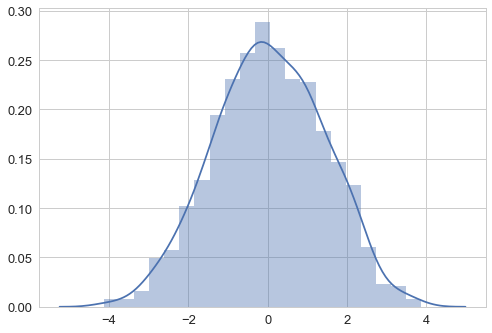

In [197]:
def ret(n, sig):
    return sum(np.random.randn() * sig for _ in range(n))

d = [ret(2, 1) for _ in range(1000)]
sns.distplot(d)
norm.fit(d)
    

In [163]:
softmax([1,1,2])

array([ 0.212,  0.212,  0.576])

In [155]:
x = np.random.rand(4)
theta = np.random.rand(4, 2)
x @ theta

array([ 1.062,  0.671])

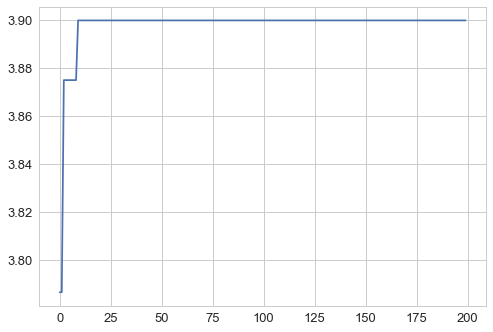

In [126]:
plt.plot(rolling_max(map(get('v'), agent.policy.node_history), 200))

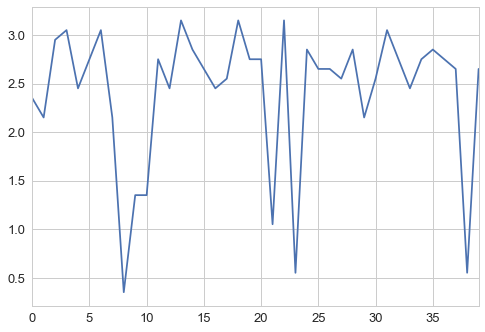

In [114]:
df = pd.DataFrame(trace)
df['return'].plot()

<Container object of 3 artists>

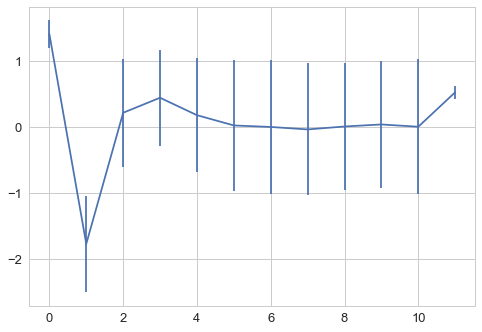

In [115]:
sns.set_style('whitegrid')
w = V.model.w
idx = [0,1,2,3,4,5,6,7,8,9,10,len(w)-1]
w = w[idx]
var = V.model.sigma_w[idx]
# plt.bar(range(len(idx)), w)
plt.errorbar(range(len(idx)), w, var)
# plt.fill_between(range(len(idx)), w-var, w+var, alpha=0.4)
# plt.ylim(-2, 2)

In [35]:
from utils import dict_product
from envs import ForageWorld
from agents import *

def rolling_max(seq, length):
    seq = iter(seq)
    best = next(seq)
    lst = np.zeros(length) - 1000
    lst[0] = best
    for i, x in enumerate(seq, start=1):
        best = max(x, best)
        lst[i] = best 
    for j in range(i, length):
        lst[j] = best
    return lst
    
        

def data(params, n=20):
    for i, pr in enumerate(params):
        print(pr)
        env = ForageWorld(**pr)
        agent = Agent()
        agent.register(env)
        V = FixedV([0, 1] + [0] * (pr['size'] ** 2))
        agent.register(V)
        agent.register(SearchPolicy(V, noise=0))
        rets = []
        for _ in range(n):
            agent.run_episode()
            nh = agent.policy.node_history
            rets.append(rolling_max(map(get('v'), nh), 2000))
        yield {**pr, 'ret': np.stack(rets).mean(0)}

params = {
    'size': [6,8,10,12],
    'n_berry': 5,
    'time_cost': 0.05,
}
df = pd.DataFrame(data(dict_product(params)))

/usr/local/lib/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


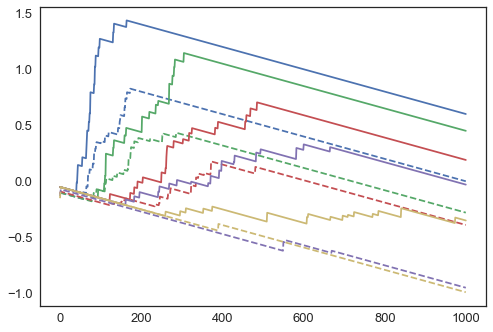

In [102]:
time_cost = np.arange(2000) * -0.001
colors = iter(sns.color_palette('deep'))
color = defaultdict(lambda: next(colors))
ls = {0.05: '-', 0.1: '--'}
for (nb, s, tc), dd in df.groupby(['n_berry', 'size', 'time_cost']):
    x = dd.ret.iloc[0] + time_cost
    plt.plot(x[:1000], c=color[s], ls=ls[tc])
plt.legend()

In [182]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Image
sns.set_style('whitegrid')

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

def get_states(path):
    env.reset()
    yield (SIZE // 2, SIZE //2)
    for a in path:
        s1, r, done, _ = env.step(a)
        yield env._state[:2]

def init():
    pathcol.set_offsets([[], []])
    return [pathcol]

def update(i, pathcol, nodes):
    data = np.array(list(get_states(nodes[i].path)))
    pathcol.set_offsets(data)
    return [pathcol]

fig = plt.figure()
ax = plt.axes(xlim=(-0.5, SIZE+.5), ylim=(-0.5, SIZE+.5))
plt.xticks(range(0,SIZE))
plt.yticks(range(0,SIZE))
ax.scatter(*np.array(list(env.berry_locs.keys())).T, 
           c='r', marker='x',  s=120)
pathcol = ax.scatter([], [], s=100)

nodes = agent.policy.node_history[200:300]
T = len(nodes)

anim = FuncAnimation(
    fig, update, init_func=init, fargs=(pathcol, nodes), interval=200, frames=T, 
    blit=True, repeat=True)

display_animation(anim)

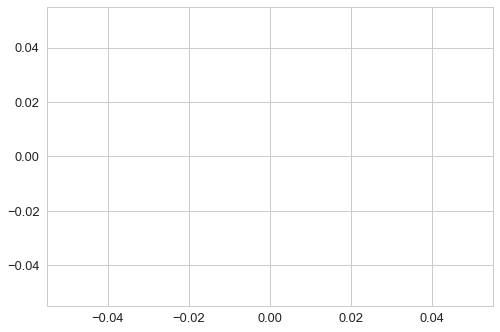

In [128]:
plot = plt.scatter([], [], s=100)
fig1 = plt.figure()
plt.axis('equal')
plt.xlim(0, SIZE)
plt.ylim(0, SIZE)

nodes = agent.policy.node_history
ani = FuncAnimation(fig1, plot_node, 20, fargs=(nodes, plot),      
                                   interval=100, blit=True)
display_animation(ani)

(-0.07166526525683771,
 1.0716652652568381,
 0.8784946236559138,
 1.508755760368663)

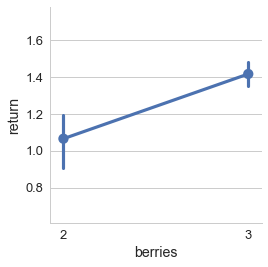

In [50]:
df = pd.DataFrame(trace)
sns.factorplot('berries', 'return', data=df)
plt.axis('equal')
# plt.plot([0, 2], [0, 2], ls='--')

In [32]:
# N_EP = 50
# trace = agent.run_many(N_EP, max_steps=100)
roll = 2

df = pd.DataFrame(trace)
cols = ['v0', 'vx', 'vy', 'vb'] 
# cols.extend(['vxy', 'vxb', 'vyb'])
tdf = pd.DataFrame(list(df.theta_v), columns=cols).clip(-10, 100)
df = df.join(tdf).drop('theta_v', axis=1)
# sns.factorplot('berries', 'return', data=df)
# df['return'].rolling(roll).mean().plot()
# sns.lmplot('i_episode', 'vb', data=df)
df[cols + ['return', 'berries']].rolling(roll).mean().plot()
plt.axhline(0, ls='--', c='gray')

AssertionError: 4 columns passed, passed data had 38 columns

2.4420864917920477

In [38]:
from sklearn.linear_model import SGDRegressor
n_samples, n_features = 100, 5
X = np.random.randn(n_samples, n_features)
theta = np.random.randn(n_features)
y = X @ theta + 0.5 * np.random.randn(n_samples)
clf = SGDRegressor()
clf.fit(X, y)
theta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
def rms_error(y1, y2):
    return ((y1 - y2) ** 2).mean() ** 0.5

print('{:.3f}  {:.3f}'.format(
    rms_error(y, clf.predict(X)),
    rms_error(y, X @ theta_hat)),
)


0.558  0.475


In [50]:
class LinearSGD(object):
    """Learns a linear approximation by SGD."""
    def __init__(self, shape, learn_rate=.1):
        self.shape = shape
        self.learn_rate = learn_rate
        self.theta = np.random.random(self.shape)

    def update(self, x, y):
        yhat = x @ self.theta
        error = y - yhat
        self.theta += self.learn_rate * np.outer(x, error)

    def predict(self, x):
        return x @ self.theta

mod = LinearSGD((n_features, 1), .1)
for i in range(len(X)):
    mod.update(X[i], y[i])

yhat = [mod.predict(x)[0] for x in X]
rms_error(y, yhat)

0.51021192985804253

In [14]:
from sklearn.linear_model import SGDRegressor
n_samples, n_features, n_output = 10, 5, 2
X = np.random.randn(n_samples, n_features)
theta = np.random.randn(n_features, n_output)
y = X @ theta
# clf = SGDRegressor()
# clf.partial_fit(X, y)
y

array([[ 2.42563877,  1.09444438],
       [ 1.59943738, -2.07547369],
       [ 1.020246  , -0.55091792],
       [ 2.60929959, -1.44009722],
       [-0.14960927, -0.90310834],
       [-2.22163198,  1.47699756],
       [-3.47033397, -1.74733514],
       [-2.26792348,  1.69821194],
       [-2.09173645,  1.45081708],
       [-6.32695908,  4.29277333]])

In [23]:
clf.fit(X, y)
theta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
def rms_error(y1, y2):
    return ((y1 - y2) ** 2).mean() ** 0.5

print('{:.3f}  {:.3f}'.format(
    rms_error(y, clf.predict(X)),
    rms_error(y, X @ theta_hat)),
)

1.041  0.509


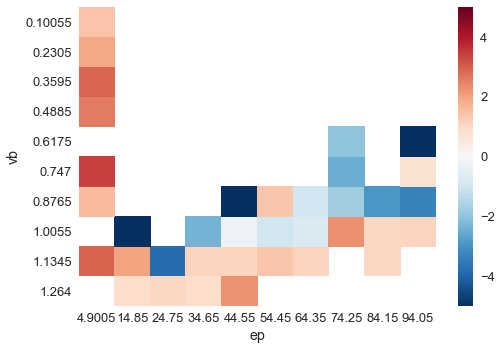

In [27]:
def bin(x):
    return pd.cut(x, 10).apply(lambda x: x.mid)

bdf = pd.DataFrame({
    'vb': bin(df.vb),
    'ep': bin(df.i_episode),
    'return': df['return']
})
sns.heatmap(bdf.pivot_table('return', 'vb', 'ep'))

In [128]:
agent.depth = 2
agent.run_episode()

{'actions': [2, 1, 0, 1, 3, 2, 1, 1, 2, 1, 2, 2],
 'finished': True,
 'i_episode': 4,
 'return': -22,
 'rewards': [-1, -1, -2, -2, -2, -1, -3, -2, -4, -3, -1, 0],
 'states': [0, 5, 6, 1, 2, 1, 6, 7, 8, 13, 14, 19, 24]}

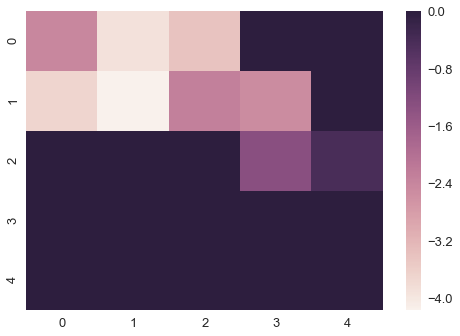

In [129]:
V = agent.V.to_array().reshape(5, 5)
sns.heatmap(V)

In [81]:
from agents import QLearningAgent
from envs import GridEnv

env = GridEnv(5, 5)
agent = QLearningAgent(env)
agent.Q.theta
# agent.Q.theta
# trace = agent.run_many(500)
agent.run_many(100)

[[ -1.336e+18   5.397e+16   6.329e+16   9.544e+14]
 [ -1.027e+18  -4.374e+16   8.271e+16   5.813e+10]]
[[ -3.293e+29   1.951e+30   1.634e+29   2.187e+30]
 [ -1.269e+29  -1.808e+31   6.028e+28   5.473e+29]]
[[ -2.126e+39   2.701e+42   3.233e+42   2.413e+41]
 [  4.245e+33  -2.503e+43   7.608e+37   6.080e+40]]
[[  2.289e+42   2.282e+45   4.025e+43   2.413e+41]
 [  2.291e+42   1.482e+45   4.085e+43   6.080e+40]]
[[  2.289e+42   6.671e+48   1.486e+50   2.413e+41]
 [  2.291e+42   8.901e+48   1.985e+50   6.080e+40]]
[[  5.822e+55   2.452e+53   3.535e+57   2.413e+41]
 [  1.163e+56   2.871e+53   6.401e+57   6.080e+40]]
[[ -5.012e+63   1.894e+64   1.922e+64   9.665e+62]
 [  1.163e+56  -1.924e+64   1.819e+64   6.080e+40]]
[[  6.734e+84   1.073e+86   3.175e+86   3.157e+85]
 [ -3.962e+81  -1.090e+86   4.231e+86   1.517e+80]]
[[  6.847e+113   8.623e+112  -2.240e+116   1.356e+103]
 [  2.337e+114   2.877e+115   2.416e+115  -1.868e+112]]
[[  3.360e+117   8.961e+121   4.039e+120  -3.961e+117]
 [  4.794e

/usr/local/lib/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:1154: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis,:], out)
/Users/fred/Projects/gymrats/agents.py:170: RuntimeWarning: invalid value encountered in subtract
  error = y - yhat


[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  

{'finished': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 'i_episode': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  

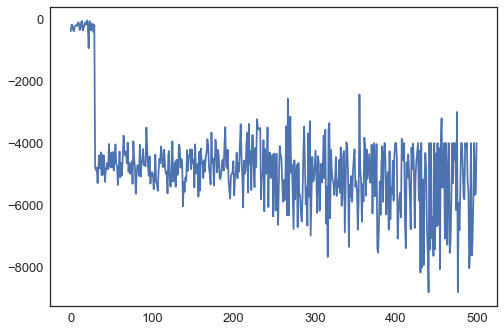

In [76]:
plt.plot(trace['return'])

[ -7.684  69.513]


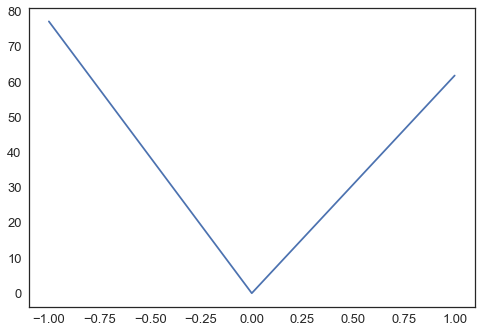

In [396]:
# agent.run_many(1000)
print(agent.V.theta)
# agent.V.theta = np.array([0, 100])
X = np.linspace(-1,1, 101)
plt.plot(X, lmap(agent.V, map(agent.phi, X)))